# Self-Driving Car Engineer Nanodegree

## **Advanced Lane Finding on the Road** 

![Cover](./writeup_imgs/cover.jpg)

---

## Overview

In this project, your goal is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car. The camera calibration images, test road images, and project videos are available in the [project repository](https://github.com/miguelangel/sdc--advanced-lane-finding).

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. A great writeup should include the [rubric](https://review.udacity.com/#!/rubrics/571/view) points as well as your description of how you addressed each point. You should include a detailed description of the code used in each step (with line-number references and code snippets where appropriate) and links to other supporting documents or external references. You should also include images in your writeup to illustrate how your code works.


## Goals/Steps

The goals / steps of this project are the following:
* Import and initialize the packages needed in the project
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
* Run pipeline in a video.

### Step 0: Import and initialize the packages needed in the project

In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import tensorflow as tf

from moviepy.editor import VideoFileClip
from IPython.display import HTML

# My humble tribute to Michael Jordan and Magic Johnson, 
# the best basketball players ever.
np.random.seed(23)
tf.set_random_seed(32)

%matplotlib inline

/Users/miguelangel/miniconda2/envs/gpu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Step 1: Compute the camera calibration using chessboard images

In [2]:
def calibrate_camera(images, nx=9, ny=6):
    """"
    images = paths to the images used to calibrate the camera
    nx = Number of inside corners in x
    ny = Number of inside corners in y
    """

    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    img = None
    for fname in images:    
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    # Camera calibration, given object points, image points, and the shape of the grayscale image
    if (len(objpoints) > 0):
        # Camera successfully calibrated.
        print("Camera successfully calibrated.")
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    else:
        # Unable to calibrate the camera.
        print("Unable to calibrate the camera.")
        ret, mtx, dist, rvecs, tvecs = (None, None, None, None, None)

    return ret, mtx, dist, rvecs, tvecs
        
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

ret, mtx, dist, rvecs, tvecs = calibrate_camera(images)

Camera successfully calibrated.


### Step 2: Apply a distortion correction to raw images

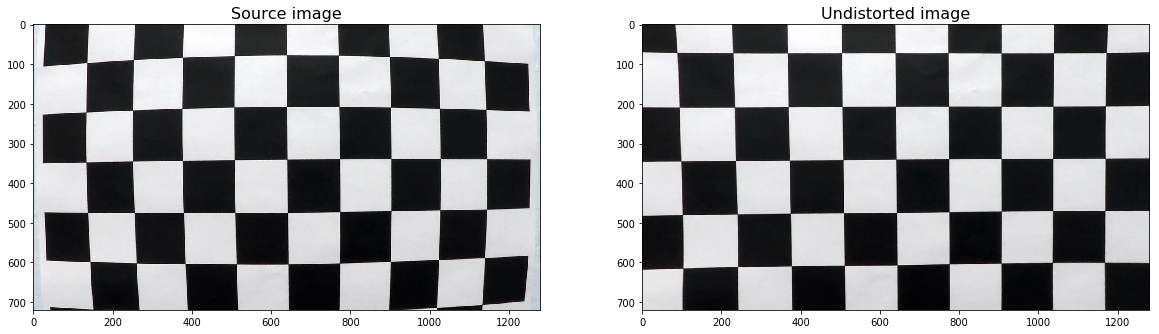

In [3]:
# Undistord a test image
img = cv2.imread('./camera_cal/calibration1.jpg')

undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)

# Helper method to plot two images side by side
def plt_images(img_1, title_1, img_2, title_2, cmap='gray'):
    # Visualize undirstorsion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title(title_1, fontsize=16)
    ax1.imshow(img_1)
    ax2.set_title(title_2, fontsize=16)
    ax2.imshow(img_2, cmap='gray')
    
plt_images(img, 'Source image', undistorted_img, 'Undistorted image')

### Step 3: Use color transforms, gradients, etc., to create a thresholded binary image.

In this step, we will define funtions to calculate several gradient measurements (x, y, magnitude, direction).

Then, we will combine all the previously calculated thresholds to isolate lane-line pixels.

In [4]:
# Load a test image, convert to RGB and undistort it
img = cv2.imread('./test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.undistort(img, mtx, dist, None, mtx)

#### Step 3.1: Calculate directional gradient

In [5]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel))
    
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

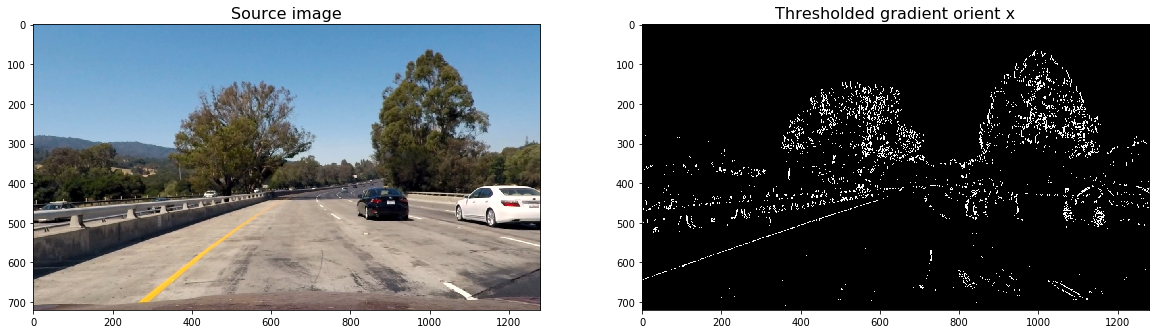

In [6]:
# Run the function
grad_x = abs_sobel_thresh(img, orient='x', sobel_kernel=15, thresh=(30, 100))

# Plot the result
plt_images(img, 'Source image', grad_x, 'Thresholded gradient orient x')

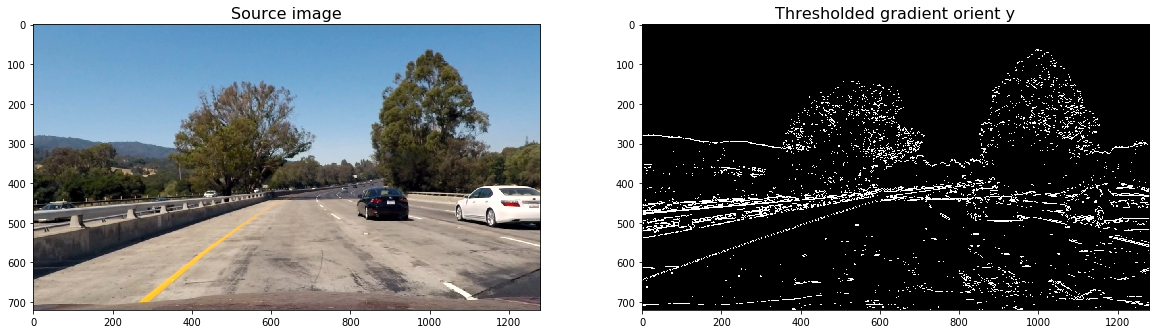

In [7]:
# Run the function
grad_y = abs_sobel_thresh(img, orient='y', sobel_kernel=15, thresh=(30, 100))

# Plot the result
plt_images(img, 'Source image', grad_y, 'Thresholded gradient orient y')

#### Step 3.2: Calculate gradient magnitude 

In [8]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thres(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

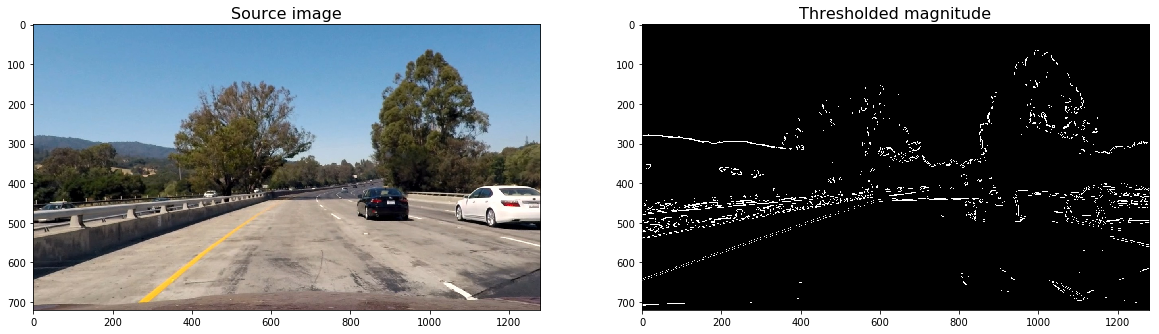

In [9]:
# Run the function
mag_binary = mag_thres(img, sobel_kernel=15, thresh=(70, 100))

# Plot the result
plt_images(img, 'Source image', mag_binary, 'Thresholded magnitude')

#### Step 3.3: Calculate gradient direction 

In [10]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_thresh(img, sobel_kernel=9, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

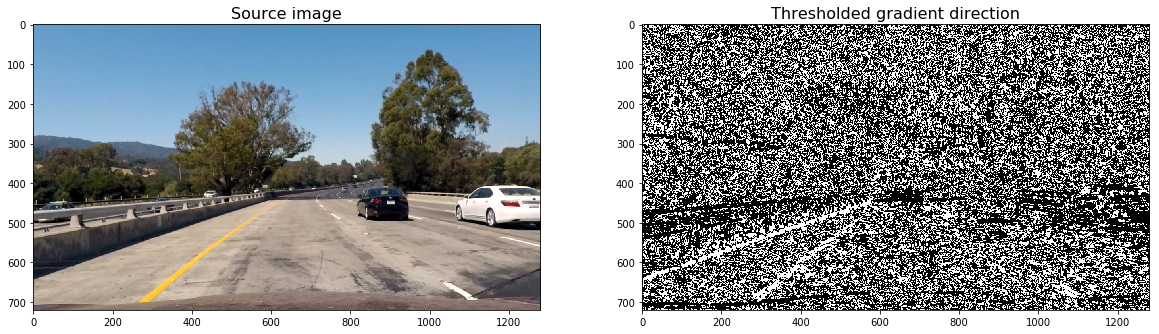

In [11]:
# Run the function
dir_binary = dir_thresh(img, sobel_kernel=15, thresh=(0.7, 1.3))

# Plot the result
plt_images(img, 'Source image', dir_binary, 'Thresholded gradient direction')

### Step 3.4: Calculate color threshold

In [12]:
def col_thresh(img, thresh=(170, 255)):
    # HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Select S channel because it is usually the best performant
    # for this task. R channel also performs similarly.
    s_channel = hls[:,:,2] 
    
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1

    # Return the binary image
    return binary_output

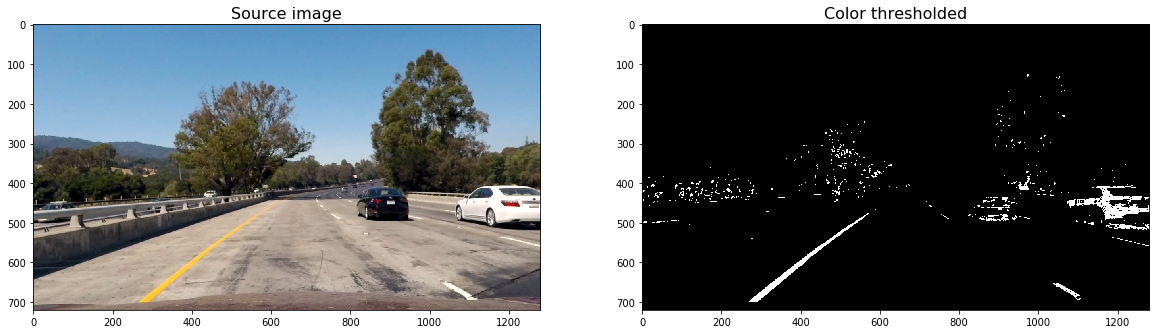

In [13]:
# Run the function
col_binary = col_thresh(img, thresh=(170, 255))

# Plot the result
plt_images(img, 'Source image', col_binary, 'Color thresholded')

### Step 3.5: Combine all the thresholds to identify the lane lines

In [14]:
def combine_threshs(grad_x, grad_y, mag_binary, dir_binary, col_binary, ksize=15):
    # Combine the previous thresholds
    combined = np.zeros_like(dir_binary)
    combined[((grad_x == 1) & (grad_y == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (col_binary == 1)] = 1

    return combined

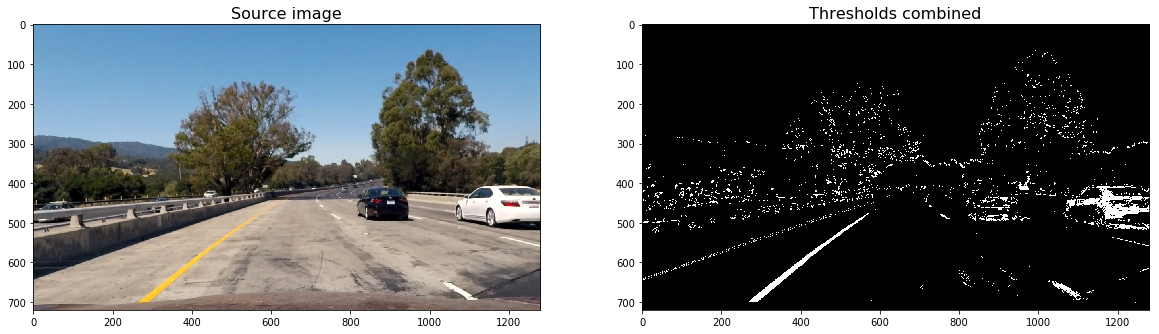

In [15]:
# Run the function
combined = combine_threshs(grad_x, grad_y, mag_binary, dir_binary, col_binary, ksize=15)

# Plot the result
plt_images(img, 'Source image', combined, 'Thresholds combined')

### Step 4: Apply a perspective transform to rectify binary image ("birds-eye view").

In [16]:
# Define perspective transform function
def warp(img, src_coordinates=None, dst_coordinates=None):
    # Define calibration box in source (original) and destination (desired or warped) coordinates
    img_size = (img.shape[1], img.shape[0])
    
    
    if src_coordinates is None:
        src_coordinates = np.float32(
            [[280,  700],  # Bottom left
             [595,  460],  # Top left
             [725,  460],  # Top right
             [1125, 700]]) # Bottom right
        
    if dst_coordinates is None:
        dst_coordinates = np.float32(
            [[250,  720],  # Bottom left
             [250,    0],  # Top left
             [1065,   0],  # Top right
             [1065, 720]]) # Bottom right   

    # Compute the perspective transfor, M
    M = cv2.getPerspectiveTransform(src_coordinates, dst_coordinates)

    
    # Compute the inverse perspective transfor also by swapping the input parameters
    Minv = cv2.getPerspectiveTransform(dst_coordinates, src_coordinates)
    
    # Create warped image - uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M, Minv

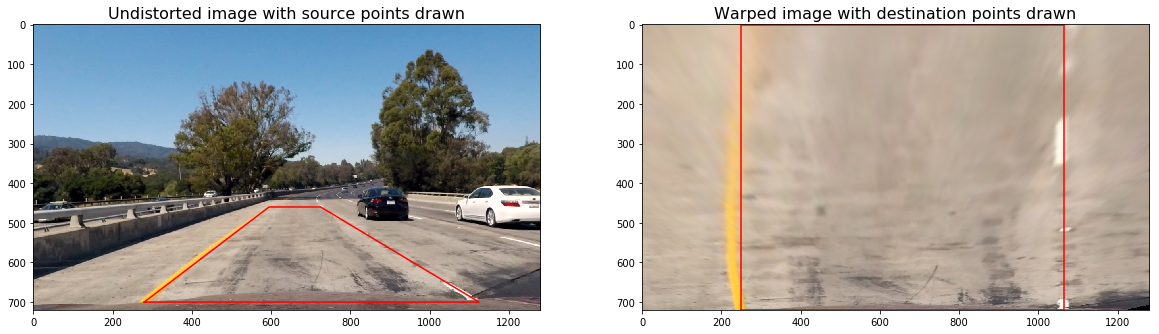

In [17]:
# Run the function
src_coordinates = np.float32(
    [[280,  700],  # Bottom left
     [595,  460],  # Top left
     [725,  460],  # Top right
     [1125, 700]]) # Bottom right

dst_coordinates = np.float32(
    [[250,  720],  # Bottom left
     [250,    0],  # Top left
     [1065,   0],  # Top right
     [1065, 720]]) # Bottom right   

warped_img, _ , Minv  = warp(img, src_coordinates, dst_coordinates)

# Visualize undirstorsion
# Notice 'img' was undistorted at the beginning
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Undistorted image with source points drawn', fontsize=16)
ax1.plot(Polygon(src_coordinates).get_xy()[:, 0], Polygon(src_coordinates).get_xy()[:, 1], color='red')
ax1.imshow(img)

ax2.set_title('Warped image with destination points drawn', fontsize=16)
ax2.plot(Polygon(dst_coordinates).get_xy()[:, 0], Polygon(dst_coordinates).get_xy()[:, 1], color='red')
ax2.imshow(warped_img)

### Step 5: Detect lane pixels and fit to find the lane boundary.

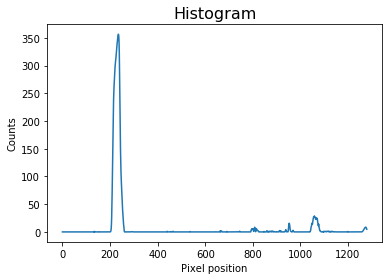

In [18]:
def get_histogram(img):
    return np.sum(img[img.shape[0]//2:, :], axis=0)

# Run de function over the combined warped image
combined_warped = warp(combined)[0]
histogram = get_histogram(combined_warped)

# Plot the results
plt.title('Histogram', fontsize=16)
plt.xlabel('Pixel position')
plt.ylabel('Counts')
plt.plot(histogram)

In [19]:
def detect_lines(img, return_img=False):
    # Take a histogram of the bottom half of the image
    histogram = get_histogram(img)

    if return_img:
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((img, img, img))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(img.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzerox = np.array(nonzero[1])   
    nonzeroy = np.array(nonzero[0])
   

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window + 1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if return_img:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 3) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if return_img:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Draw left and right lines
        for index in range(img.shape[0]):
            cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
            cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))
            
        return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img.astype(int)

    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty)


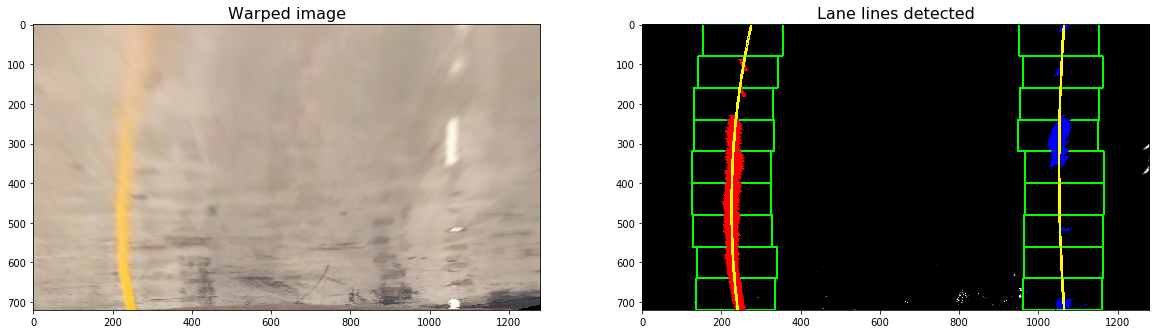

In [20]:
# Run the function
lines_fit, left_points, right_points, out_img = detect_lines(combined_warped, return_img=True)

# Plot the results
plt_images(warped_img, 'Warped image', out_img, 'Lane lines detected')


In [21]:
def detect_similar_lines(img, line_fits=None, return_img=False):
    if line_fits is None:
        return detect_lines(img, return_img)
    
    left_fit = line_fits[0]
    right_fit = line_fits[1]
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # If any of the lines could not be found, 
    # perform a more exhaustive search
    if (leftx.size == 0 or rightx.size == 0):
        return detect_lines(img, return_img)
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    if return_img:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((img, img, img))*255
        window_img = np.zeros_like(out_img)

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
     
        for index in range(img.shape[0]):
            cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
            cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))
    
        return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img.astype(int)
    
    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty)

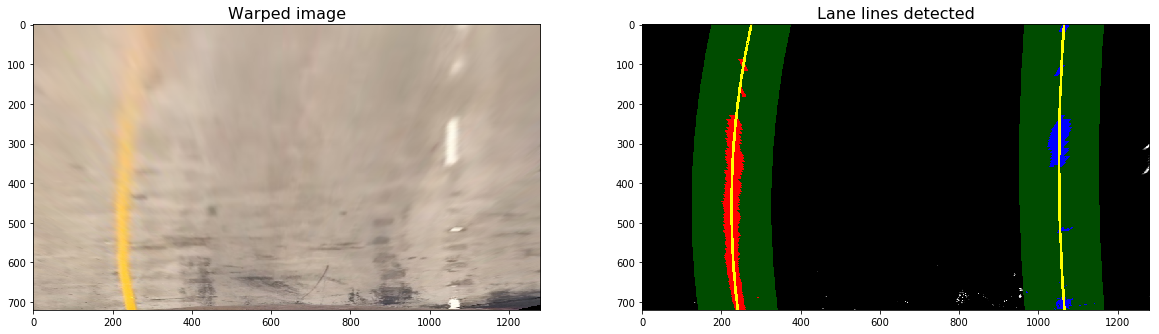

In [22]:
# Run the function
# Notice I am passing the same image than before.
# In a video stream, it should be passed the next image.
lines_fit, left_points, right_points, out_img = detect_similar_lines(combined_warped, lines_fit, return_img=True)

# Plot the results
plt_images(warped_img, 'Warped image', out_img, 'Lane lines detected')

### Step 6: Determine the curvature of the lane and vehicle position with respect to center.

In [23]:
def curvature_radius (leftx, rightx, ploty, xm_per_pix=3.7/700, ym_per_pix = 30/720):
    leftx = left_points[0]
    rightx = right_points[0]
    ploty = left_points[1]


    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad)

In [24]:
# Run the function
curvature_rads = curvature_radius(leftx=left_points[0], rightx=right_points[0], ploty = left_points[1])

# Print the results
print('Left line curvature:', curvature_rads[0], 'm')
print('Right line curvature:', curvature_rads[1], 'm')

Left line curvature: 691.0380197795405 m
Right line curvature: 1602.1189011905674 m


### Step 7: Warp the detected lane boundaries back onto the original image.

In [25]:
def draw_lane(img, warped_img, left_points, right_points, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = left_points[0]
    right_fitx = right_points[0]
    ploty = left_points[1]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

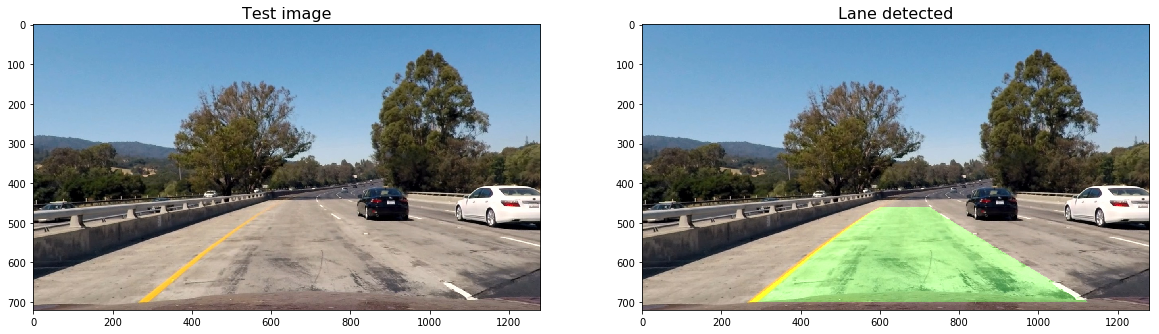

In [26]:
# Run the function
img_lane = draw_lane(img, combined_warped, left_points, right_points, Minv)

# Plot the results
plt_images(img, 'Test image', img_lane, 'Lane detected')

### Step 8: Display lane boundaries and numerical estimation of lane curvature and vehicle position.


### Step 9: Run pipeline in a video.

In [27]:
class ProcessImage:
    def __init__(self, images):
        # Make a list of calibration images
        images = glob.glob(images)

        # Calibrate camera
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = calibrate_camera(images)
        self.lines_fit = None

    def __call__(self, img):
        # Undistord image
        img = cv2.undistort(img, mtx, dist, None, mtx)

        # Calculate directional gradient
        grad_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=15, thresh=(30, 100))

        # Calculate gradient magnitude 
        mag_binary = mag_thres(img, sobel_kernel=15, thresh=(50, 100))

        # Calculate gradient direction
        dir_binary = dir_thresh(img, sobel_kernel=15, thresh=(0.7, 1.3))

        # Calculate color threshold
        col_binary = col_thresh(img, thresh=(170, 255))

        # Combine all the thresholds to identify the lane lines
        combined = combine_threshs(grad_x, grad_y, mag_binary, dir_binary, col_binary, ksize=15)

        # Apply a perspective transform to rectify binary image ("birds-eye view")
        src_coordinates = np.float32(
            [[280,  700],  # Bottom left
             [595,  460],  # Top left
             [725,  460],  # Top right
             [1125, 700]]) # Bottom right

        dst_coordinates = np.float32(
            [[250,  720],  # Bottom left
             [250,    0],  # Top left
             [1065,   0],  # Top right
             [1065, 720]]) # Bottom right   

        combined_warped, _, Minv = warp(combined, src_coordinates, dst_coordinates)
                
        self.lines_fit, left_points, right_points, out_img = detect_similar_lines(combined_warped, self.lines_fit, return_img=True)

        # Warp the detected lane boundaries back onto the original image.
        img_lane = draw_lane(img, combined_warped, left_points, right_points, Minv)
            
        return img_lane

In [29]:
input_video = './project_video.mp4'
output_video = './project_video_with_lane.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip(input_video).subclip(0,5)
clip1 = VideoFileClip(input_video)

# Process video frames with our 'process_image' function
process_image = ProcessImage('./camera_cal/calibration*.jpg')

white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(output_video, audio=False)

Camera successfully calibrated.
[MoviePy] >>>> Building video ./project_video_with_lane.mp4
[MoviePy] Writing video ./project_video_with_lane.mp4


100%|█████████▉| 1260/1261 [35:56<00:01,  1.71s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_with_lane.mp4 

CPU times: user 14min 1s, sys: 45.7 s, total: 14min 47s
Wall time: 35min 57s


In [30]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output_video))